# How to Find Missing Values?

For starters, we need to test if assigning the frequency lead to additional time periods for which data is Not Available.

Again, there’s a dedicated method: is_na() which we can call on the entire data frame. We will see either “True” or “False” for every entry in the set, depending on whether there is missing data for that period.

In [1]:
# lIBRARIES FOR NOTEBOOK
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

# Read & Import CSV file as dataframe
df = pd.read_csv('Index2018.csv')

# Detect missing values. Return a boolean same-sized object indicating if the values are NA. 
# NA values, such as None or numpy.NaN, gets mapped to True values.
df.isna()

,date,spx,dax,ftse,nikkei
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
6264,False,False,False,False,False
6265,False,False,False,False,False
6266,False,False,False,False,False
6267,False,False,False,False,False


To clarify, “True” indicates there are missing values and “False” suggests there aren’t.

The bigger the dataset, the more difficult it becomes to spot missing entries. In binary “True” is equivalent to 1 and “False” is equivalent to 0. Therefore, we can add up the values in each column to determine the number of missing observations. For convenience, we can call the “sum()” method along with “is_na()”, like so:

For each attribute, this will determine the number of instances without available information.

After running the cell, we see there are exactly 8 missing values for each of the market indexes.

In [2]:
df.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

Recall that we had no missing values when we first examined the dataset.

In [3]:
df.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

Therefore, setting the frequency to “business days” must have generated 8 dates, for which we have no data available.

# How to treat missing values in a time series?

Sometimes, your time series will have missing dates/times. That means, the data was not captured or was not available for those periods. It could so happen the measurement was zero on those days, in which case, case you may fill up those periods with zero.

Secondly, when it comes to time series, you should typically NOT replace missing values with the mean of the series, especially if the series is not stationary. What you could do instead for a quick and dirty workaround is to forward-fill the previous value.

However, depending on the nature of the series, you want to try out multiple approaches before concluding. Some effective alternatives to imputation are:

- Backward Fill
- Linear Interpolation
- Quadratic interpolation
- Mean of nearest neighbors
- Mean of seasonal couterparts



To measure the imputation performance, I manually introduce missing values to the time series, impute it with above approaches and then measure the mean squared error of the imputed against the actual values.

C:\Users\mreve\AppData\Local\Temp\ipykernel_3464\3874867326.py:70: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(ts_seas)):


<AxesSubplot: title={'center': 'Seasonal Mean (MSE: 0.78)'}, xlabel='date'>

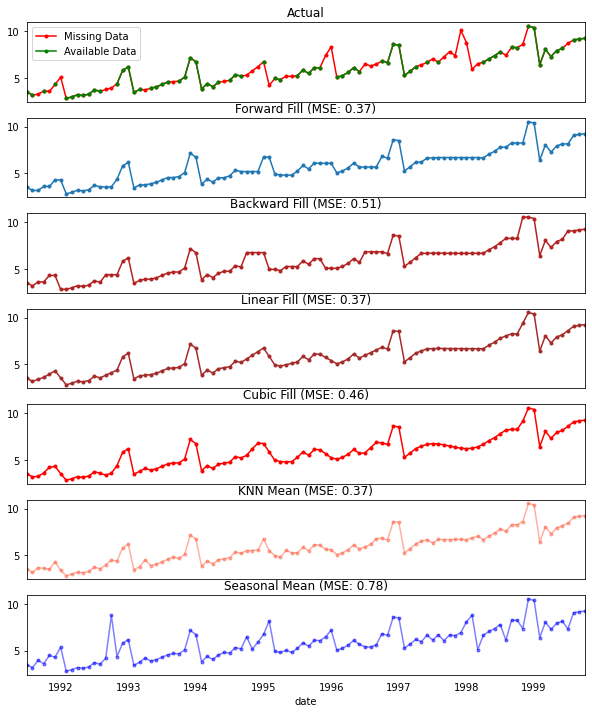

In [8]:
# # Generate dataset
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
df_orig = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date').head(100)
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10_missings.csv', parse_dates=['date'], index_col='date')

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-")


You could also consider the following approaches depending on how accurate you want the imputations to be.

- If you have explanatory variables use a prediction model like the random forest or k-Nearest Neighbors to predict it.
- If you have enough past observations, forecast the missing values.
- If you have enough future observations, backcast the missing values
- Forecast of counterparts from previous cycles.